### Imports

In [ ]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
import os
# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Optimisation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score

# Machine LearninG
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import log_loss

# Evaluation
# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt


### Import Preprocessed Data

In [ ]:
# Construct the file path
file_path = os.path.join('Data Augmented', 'XAU_USD_M15_AUGMENTED_MULTICLASS.pkl')

# Load the dataset
df = pd.read_pickle(file_path)

In [ ]:
# Assuming the last column is the target variable and the rest are features
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Now, let's perform some checks to ensure it worked
print("Shape of entire DataFrame: ", df.shape)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check the first few records to ensure the split looks correct
print("\nFirst 5 rows of features (X):")
print(X.head())
print("\nFirst 5 rows of target (y):")
print(y.head())

# Check the types to confirm they are pandas DataFrames/Series
print("\nType of X: ", type(X))
print("Type of y: ", type(y))


Shape of entire DataFrame:  (23562, 27)
Shape of X:  (23562, 26)
Shape of y:  (23562,)

First 5 rows of features (X):
       PC_0      PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
0 -6.254425  2.829216 -4.891684 -2.845976  4.008486 -8.555140  5.862690   
1 -3.850872  4.903726 -1.756492 -5.537689  2.208127 -4.524315  3.431820   
2 -1.095318  5.893986 -0.804774 -5.597807  2.819885 -6.055102  5.503417   
3  2.351989  7.265397  1.256356 -5.356025  4.113341 -6.214222  3.473383   
4  0.294494  5.522330 -1.981066 -4.531020  2.242955 -5.241408  3.138588   

        PC_7      PC_8      PC_9  ...     PC_16     PC_17      PC_18  \
0   7.165960  3.078656  3.506201  ...  3.422188 -2.717913 -14.004499   
1  11.216646 -0.391129  3.273041  ...  2.816306 -1.706859 -10.416053   
2   9.982037  1.918705  5.091947  ...  3.110125 -3.930625  -6.267588   
3   9.101391  0.924793  5.216997  ...  2.856252 -0.231934 -13.271259   
4  10.148424  0.734575  5.403931  ...  3.014510 -1.393204 -10.976878   

### Train Test Split

In [ ]:
# Assuming X and y are your features and labels respectively and they are already ordered sequentially
dataset_size = len(X)
train_size = int(dataset_size * 0.7)  # 70% of data for training

# Split the dataset into training set and test set without shuffling
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [ ]:
size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (16493, 26)
Shape of y_train:  (16493,)
Shape of X_test:  (7069, 26)
Shape of y_test:  (7069,)
Size Matches:  True


### Build Initial Model

### Find Hyperparameters

In [ ]:
space = {
    "n_estimators": hp.choice("n_estimators", range(50, 1001, 50)),
    "max_depth": hp.choice("max_depth", [None] + list(range(3, 31))),
    "min_samples_split": hp.choice("min_samples_split", range(2, 21)),
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 21)),
    "max_features": hp.choice("max_features", ['sqrt', 'log2', None, 0.5, 0.75, 1.0]),
    "criterion": hp.choice("criterion", ['gini', 'entropy']),
    "class_weight": hp.choice("class_weight", [None, 'balanced', 'balanced_subsample']),
    "bootstrap": True,  # Changed to allow both True and False
    "min_impurity_decrease": hp.uniform("min_impurity_decrease", 0.0, 0.05),
    "ccp_alpha": hp.uniform("ccp_alpha", 0.0, 0.05),
    "max_samples": hp.choice('max_samples', [None] + [i/10.0 for i in range(1, 11)])  # Corrected range and list comprehension
}

In [ ]:
# Objective function for hyperparameter optimization
def hyperopt_objective(space):
    # Create the RandomForestClassifier with the parameters
    classifier = RandomForestClassifier(**space)

    # Setup Time Series Cross-Validator
    tscv = TimeSeriesSplit(n_splits=5)

    # Calculate the cross-validation score
    accuracy_scores = cross_val_score(classifier, X_train, y_train, cv=tscv, scoring='accuracy')

    # Our goal is to maximize accuracy, so we return it as a negative value for minimization
    return {'loss': -np.mean(accuracy_scores), 'status': STATUS_OK}

# Assuming X_train and y_train are already defined and preprocessed
# Initialize a Trials object to store the results of each evaluation
trials = Trials()

# Run the hyperparameter search using the Tree of Parzen Estimators (TPE) algorithm
best = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Set this to the number of evaluations you want to perform
    trials=trials
)

# Retrieve the best hyperparameters from the trials object

print("Best hyperparameters:", best_hyperparams)

100%|███████████████████████████████████████████████████| 50/50 [2:17:24<00:00, 164.90s/trial, best loss: -0.7341339155749635]
Best hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


NameError: name 'trials' is not defined

In [ ]:
# Use space_eval to get the actual hyperparameters from the `best` indices
actual_best_params = space_eval(space, best)

# Create the RandomForestClassifier with the best parameters
classifier_1 = RandomForestClassifier(**actual_best_params, random_state=42)


### Train Model

In [ ]:
# Fit the model on the training data
classifier_1.fit(X_train, y_train)


RandomForestClassifier(ccp_alpha=0.003707279819845054, criterion='entropy',
                       max_depth=30, max_samples=0.2,
                       min_impurity_decrease=0.003372813954342839,
                       min_samples_leaf=5, min_samples_split=4,
                       n_estimators=600, random_state=42)

### Make Predictions

In [ ]:
# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, classifier_1.predict(X_train))
test_accuracy = accuracy_score(y_test, classifier_1.predict(X_test))

In [ ]:
# Calculate precision scores
precision_scores_train = precision_score(y_train, classifier_1.predict(X_train), average=None)
precision_scores_test = precision_score(y_test, classifier_1.predict(X_test), average=None)

In [ ]:
# Output the results
print("TRAIN:")
print("Accuracy:", train_accuracy)
print("Precision Scores:", precision_scores_train)

print("TEST:")
print("Accuracy:", test_accuracy)
print("Precision Scores:", precision_scores_test)

TRAIN:
Accuracy: 0.7505608439944219
Precision Scores: [0.66501508 0.78312038 0.78502456]
TEST:
Accuracy: 0.7173574763049936
Precision Scores: [0.60419717 0.7629539  0.76411055]


In [ ]:
values

NameError: name 'values' is not defined

In [ ]:
# Make predictions on the test set
y_pred = classifier_1.predict(X_test)


In [ ]:
# Calculate the classification report
report = classification_report(y_test, y_pred)


In [ ]:
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      2340
           1       0.76      0.81      0.78      2314
           2       0.76      0.81      0.79      2415

    accuracy                           0.72      7069
   macro avg       0.71      0.72      0.71      7069
weighted avg       0.71      0.72      0.71      7069



In [ ]:
SUMMARY

NameError: name 'SUMMARY' is not defined

In [ ]:
confusion matrix

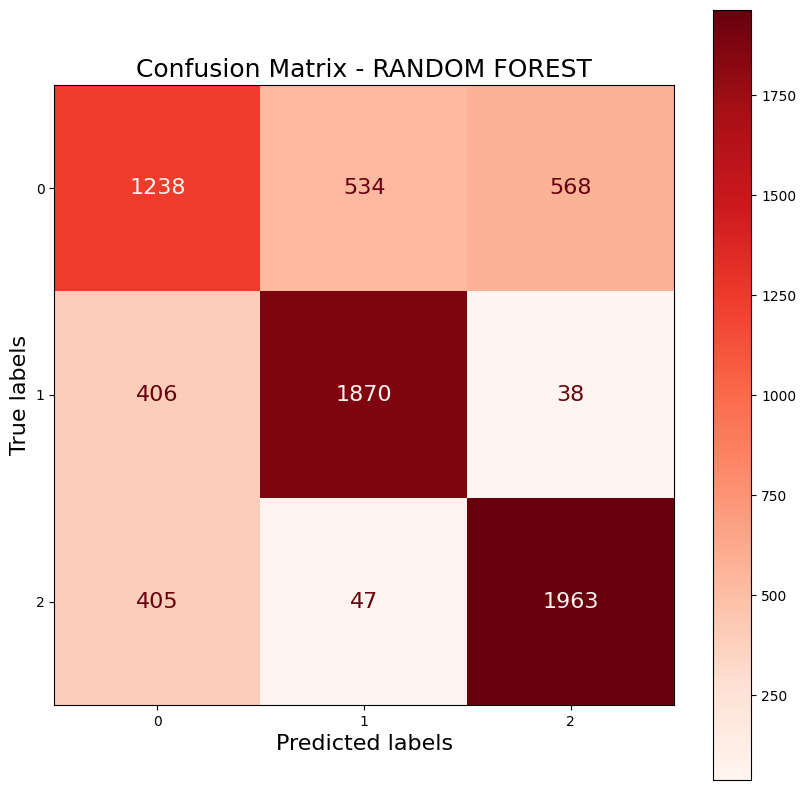

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size for better visibility
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Reds')

# Scale up the labels and title
LABEL_FONT_SIZE = 16
TITLE_FONT_SIZE = 18

ax.set_xlabel('Predicted labels', fontsize=LABEL_FONT_SIZE)
ax.set_ylabel('True labels', fontsize=LABEL_FONT_SIZE)
ax.set_title('Confusion Matrix - RANDOM FOREST', fontsize=TITLE_FONT_SIZE)

# Scale up the numbers inside the confusion matrix
for text in ax.texts:
    text.set_fontsize(LABEL_FONT_SIZE)

plt.show()

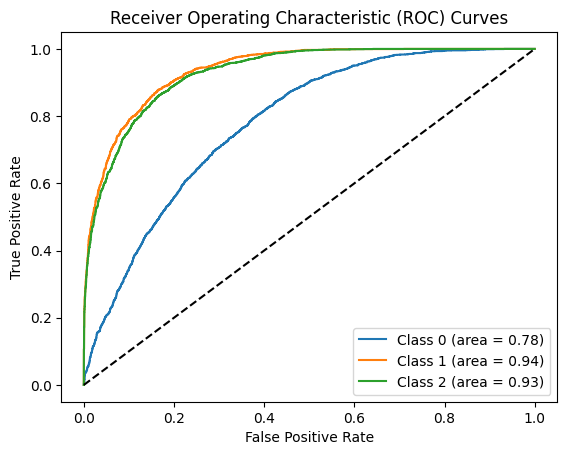

Micro-average AUC: 0.89


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_proba = classifier_1.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f'Micro-average AUC: {roc_auc["micro"]:.2f}')

In [ ]:
# Assuming test_yhat is your NumPy array
df_signal = pd.DataFrame(test_yhat, columns=['signal'])

In [ ]:
# Save the DataFrame to a CSV file
df_signal.to_csv('signal_multiclass_forest.csv', index=False)